In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np

In [4]:
import statsmodels.api as sm

# 0. Data

- Source: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final
- Original Source: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls

In [5]:
df = pd.read_csv("./data.csv", encoding="latin")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [7]:
df.columns = [x.replace(" ", "") for x in df.columns]

In [8]:
df.head()

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [9]:
df["Category"].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

# 1. Time-Series Basics

In [10]:
df["OrderDate"] = pd.to_datetime(df["OrderDate"])
ts_df = df[[
    "OrderID", "OrderDate", "Quantity", "Sales", "Category"
]].copy().set_index("OrderDate")

In [11]:
ts_df.head()

,OrderID,Quantity,Sales,Category
OrderDate,,,,
2016-11-08,CA-2016-152156,2,261.9600,Furniture
2016-11-08,CA-2016-152156,3,731.9400,Furniture
2016-06-12,CA-2016-138688,2,14.6200,Office Supplies
2015-10-11,US-2015-108966,5,957.5775,Furniture
2015-10-11,US-2015-108966,2,22.3680,Office Supplies


## 1.1. Monthly Stats

In [12]:
monthly_unique_orders = ts_df["OrderID"].resample("MS").nunique()
monthly_unique_order_changes = (
    monthly_unique_orders - monthly_unique_orders.shift()
)/monthly_unique_orders.shift()*100

monthly_quantities = ts_df["Quantity"].resample("MS").sum()
monthly_quantities_changes = (
    monthly_quantities - monthly_quantities.shift()
)/monthly_quantities.shift()*100

monthly_sales = ts_df["Sales"].resample("MS").sum()
monthly_sales_changes = (
    monthly_sales - monthly_sales.shift()
)/monthly_sales.shift()*100


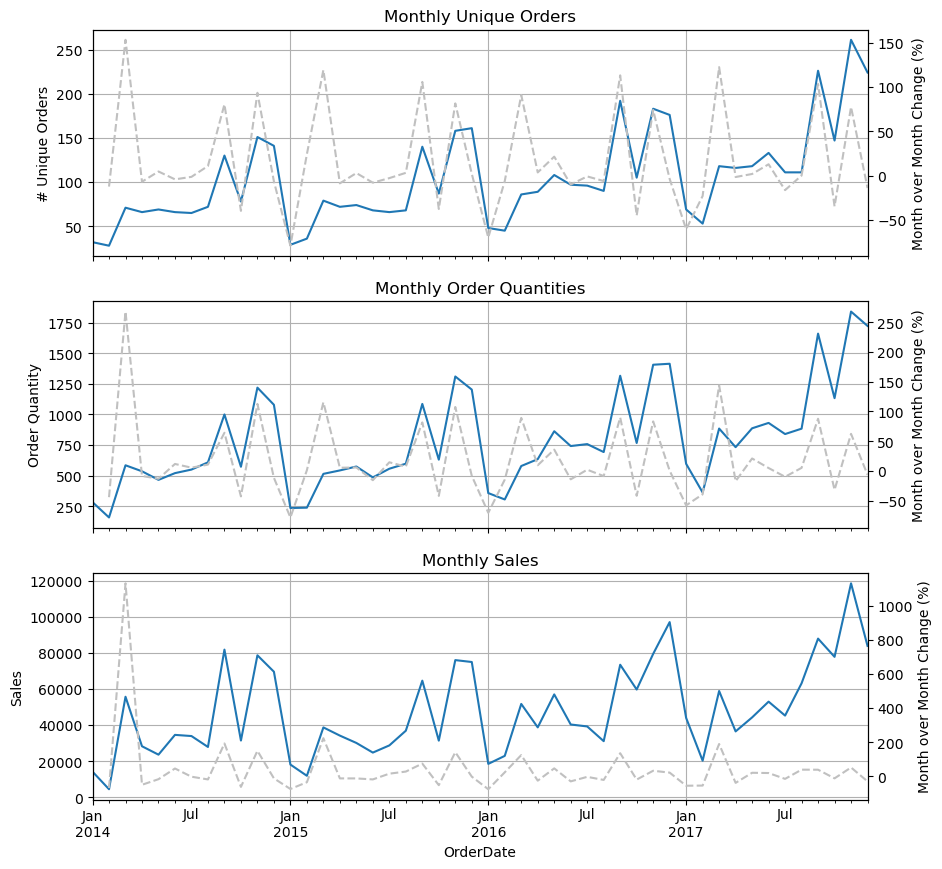

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

monthly_unique_orders.plot(
    ax=axes[0], grid=True
)
monthly_unique_order_changes.plot(
    ax=axes[0], secondary_y=True, color="silver", linestyle="dashed"
)
axes[0].set_title("Monthly Unique Orders")
axes[0].set_ylabel("# Unique Orders")
axes[0].right_ax.set_ylabel("Month over Month Change (%)")

monthly_quantities.plot(
    ax=axes[1], grid=True
)
monthly_quantities_changes.plot(
    ax=axes[1], secondary_y=True, color="silver", linestyle="dashed"
)
axes[1].set_title("Monthly Order Quantities")
axes[1].set_ylabel("Order Quantity")
axes[1].right_ax.set_ylabel("Month over Month Change (%)")

monthly_sales.plot(
    ax=axes[2], grid=True
)
monthly_sales_changes.plot(
    ax=axes[2], secondary_y=True, color="silver", linestyle="dashed"
)
axes[2].set_title("Monthly Sales")
axes[2].set_ylabel("Sales")
axes[2].right_ax.set_ylabel("Month over Month Change (%)")

plt.show()


## 1.2. Moving Averages

In [14]:
m6_ma_sales = monthly_sales.rolling(6).mean()
m6_ma_sales_std = monthly_sales.rolling(6).std()

m12_ma_sales = monthly_sales.rolling(12).mean()
m12_ma_sales_std = monthly_sales.rolling(12).std()

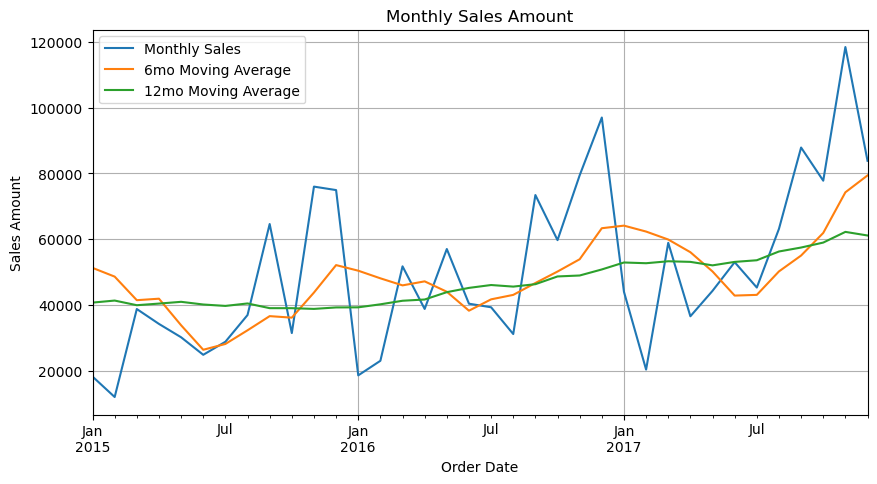

In [15]:
ax = monthly_sales["2015-01-01":].plot(figsize=(10,5))
m6_ma_sales["2015-01-01":].plot(ax=ax, grid=True)
m12_ma_sales["2015-01-01":].plot(ax=ax, grid=True)

ax.set_ylabel("Sales Amount")
ax.set_xlabel("Order Date")
ax.set_title("Monthly Sales Amount")
plt.legend(["Monthly Sales", "6mo Moving Average", "12mo Moving Average"])
plt.show()

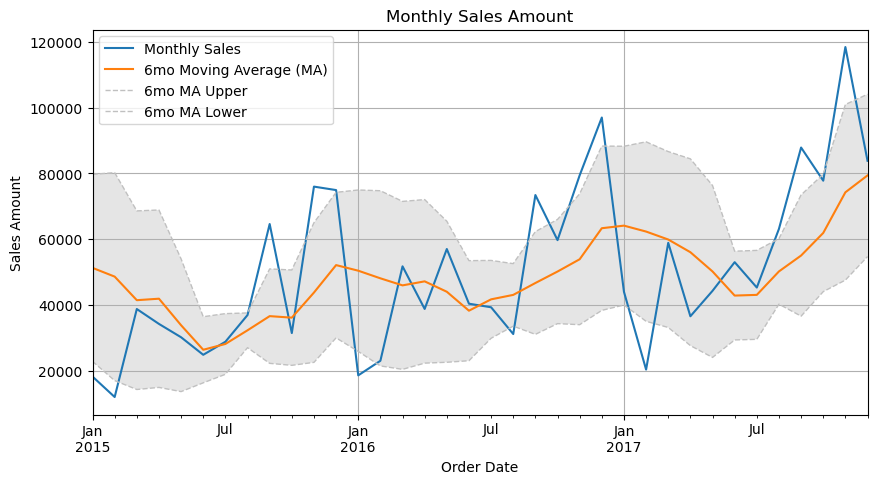

In [16]:
ax = monthly_sales["2015-01-01":].plot(figsize=(10,5))
m6_ma_sales["2015-01-01":].plot(ax=ax, grid=True)
(m6_ma_sales["2015-01-01":] + m6_ma_sales_std["2015-01-01":]).plot(
    ax=ax, grid=True, linestyle="dashed", color="silver", linewidth=1
)
(m6_ma_sales["2015-01-01":] - m6_ma_sales_std["2015-01-01":]).plot(
    ax=ax, grid=True, linestyle="dashed", color="silver", linewidth=1
)

ax.set_ylabel("Sales Amount")
ax.set_xlabel("Order Date")
ax.set_title("Monthly Sales Amount")

dates = m6_ma_sales["2015-01-01":].index
plt.fill_between(
    dates,
    m6_ma_sales["2015-01-01":] + m6_ma_sales_std["2015-01-01":],
    m6_ma_sales["2015-01-01":] - m6_ma_sales_std["2015-01-01":],
    facecolor="grey",
    alpha=0.2,
)

plt.legend(["Monthly Sales", "6mo Moving Average (MA)", "6mo MA Upper", "6mo MA Lower"])
plt.show()

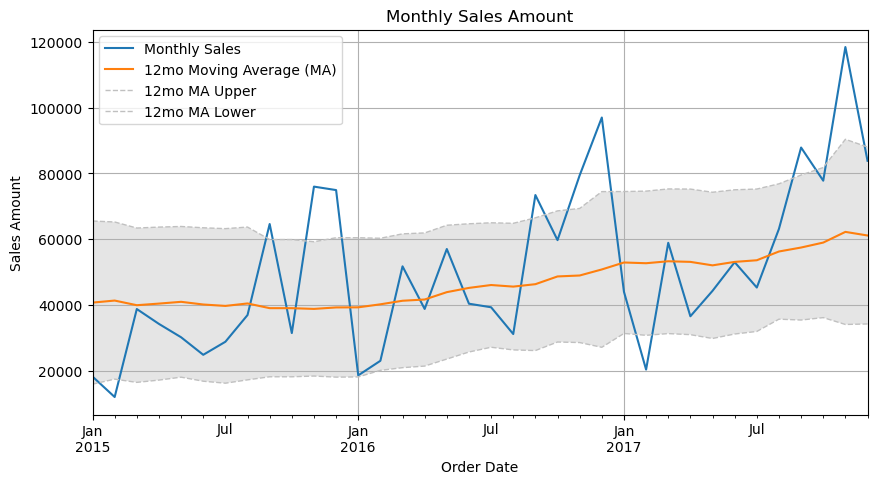

In [17]:
ax = monthly_sales["2015-01-01":].plot(figsize=(10,5))
m12_ma_sales["2015-01-01":].plot(ax=ax, grid=True)
(m12_ma_sales["2015-01-01":] + m12_ma_sales_std["2015-01-01":]).plot(
    ax=ax, grid=True, linestyle="dashed", color="silver", linewidth=1
)
(m12_ma_sales["2015-01-01":] - m12_ma_sales_std["2015-01-01":]).plot(
    ax=ax, grid=True, linestyle="dashed", color="silver", linewidth=1
)

ax.set_ylabel("Sales Amount")
ax.set_xlabel("Order Date")
ax.set_title("Monthly Sales Amount")

dates = m12_ma_sales["2015-01-01":].index
plt.fill_between(
    dates,
    m12_ma_sales["2015-01-01":] + m12_ma_sales_std["2015-01-01":],
    m12_ma_sales["2015-01-01":] - m12_ma_sales_std["2015-01-01":],
    facecolor="grey",
    alpha=0.2,
)

plt.legend(["Monthly Sales", "12mo Moving Average (MA)", "12mo MA Upper", "12mo MA Lower"])
plt.show()

## 1.3. Autocorrelation

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


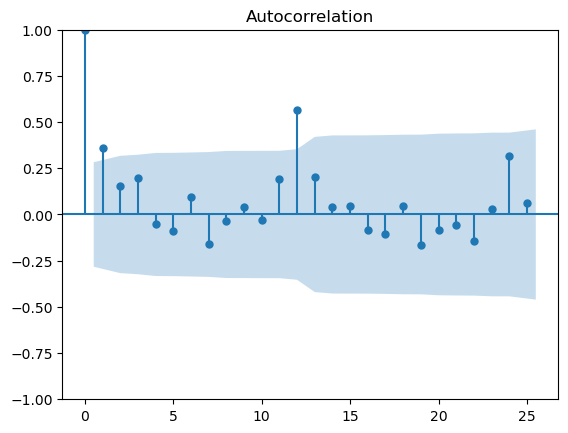

In [19]:
plot_acf(
    monthly_sales, lags=25
)
plt.show()

/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


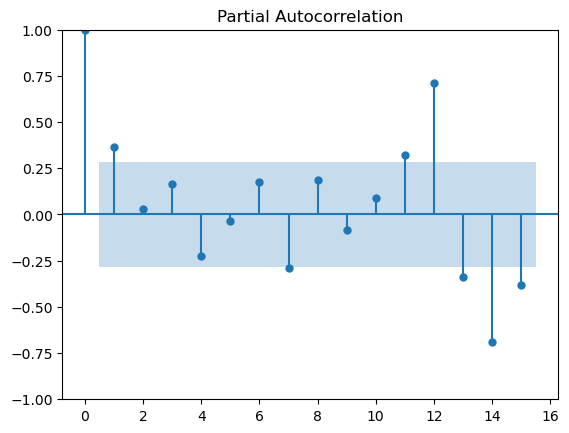

In [20]:
plot_pacf(
    monthly_sales, lags=15
)
plt.show()

## 1.4. Trends of Different Products

In [21]:
ts_df["Category"].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [22]:
furniture_monthly_sales = ts_df.loc[
    ts_df["Category"] == "Furniture"
]["Sales"].resample("MS").sum()

office_monthly_sales = ts_df.loc[
    ts_df["Category"] == "Office Supplies"
]["Sales"].resample("MS").sum()

tech_monthly_sales = ts_df.loc[
    ts_df["Category"] == "Technology"
]["Sales"].resample("MS").sum()

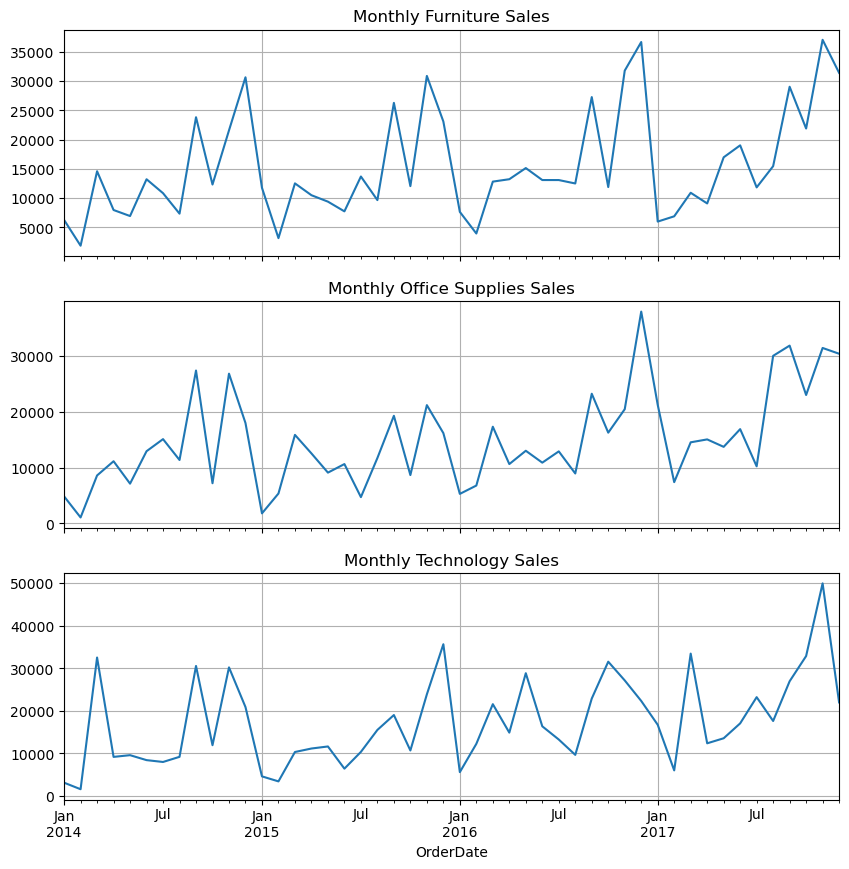

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

furniture_monthly_sales.plot(ax=axes[0], grid=True)
axes[0].set_title("Monthly Furniture Sales")

office_monthly_sales.plot(ax=axes[1], grid=True)
axes[1].set_title("Monthly Office Supplies Sales")

tech_monthly_sales.plot(ax=axes[2], grid=True)
axes[2].set_title("Monthly Technology Sales")

plt.show()


# 2. Trend + Seasonality Decomposition

In [24]:
import statsmodels.api as sm

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

## 2.1. Additive

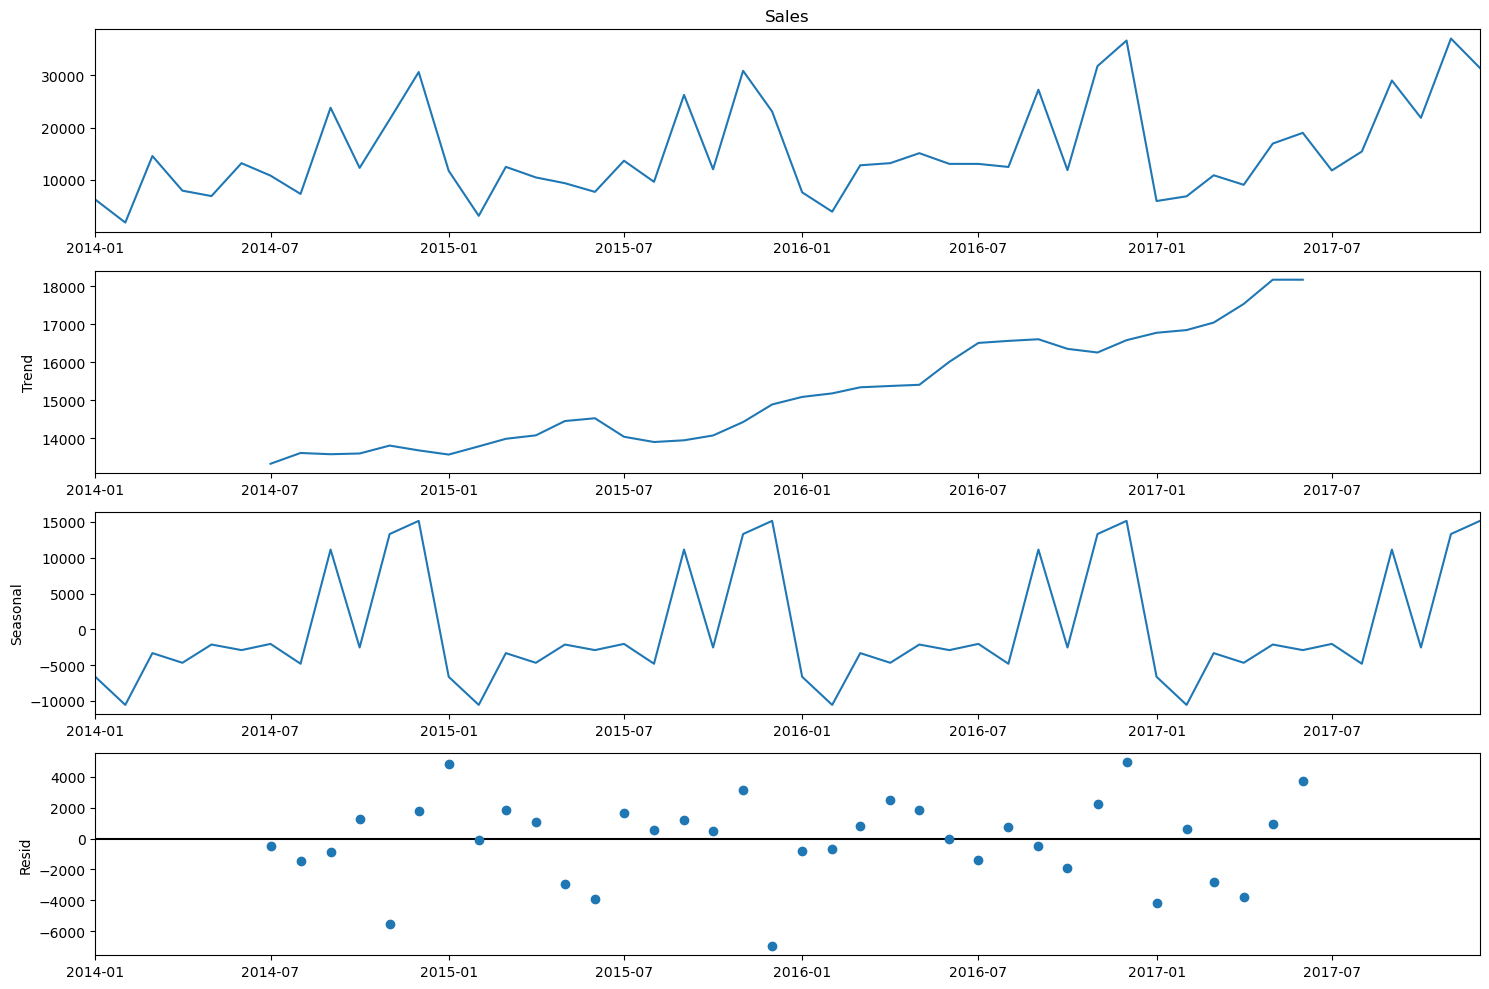

In [26]:
decomposition = sm.tsa.seasonal_decompose(
    furniture_monthly_sales, model='additive'
)
fig = decomposition.plot()
plt.show()

In [27]:
reconstructed_wo_resid = decomposition.trend + decomposition.seasonal

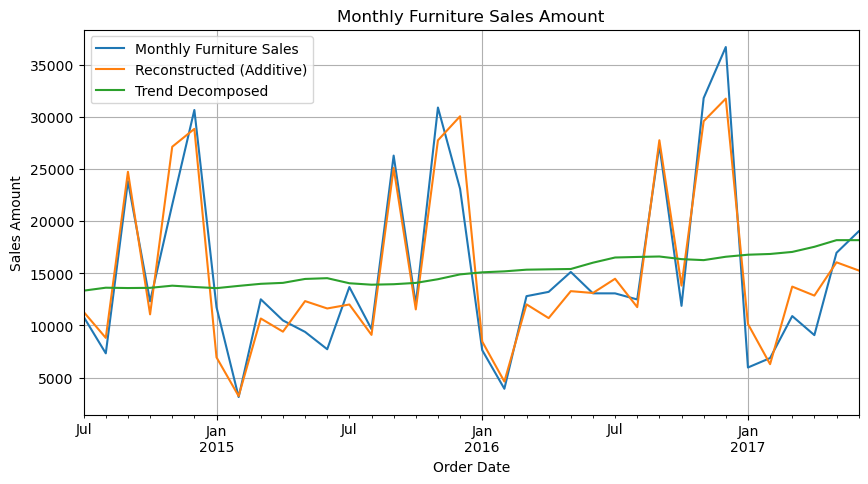

In [28]:
dates = reconstructed_wo_resid.dropna().index
ax = furniture_monthly_sales[dates].plot(figsize=(10,5))
reconstructed_wo_resid[dates].plot(ax=ax, grid=True)
decomposition.trend[dates].plot(ax=ax, grid=True)

ax.set_ylabel("Sales Amount")
ax.set_xlabel("Order Date")
ax.set_title("Monthly Furniture Sales Amount")

plt.legend(["Monthly Furniture Sales", "Reconstructed (Additive)", "Trend Decomposed"])
plt.show()


In [29]:
corr = np.corrcoef(
    list(furniture_monthly_sales[dates]), 
    list(reconstructed_wo_resid[dates])
)[0,1]
dist = np.sqrt(
    np.square(
        furniture_monthly_sales[dates] - reconstructed_wo_resid[dates]
    ).sum()
)
rmse = np.sqrt(
    np.square(
        furniture_monthly_sales[dates] - reconstructed_wo_resid[dates]
    ).mean()
)

print(f"Correlation: {corr:.02f}, Euclidean Distance: {dist:.02f}, RMSE: {rmse:.02f}")

Correlation: 0.95, Euclidean Distance: 15995.62, RMSE: 2665.94


In [30]:
print(f"Correlation: {corr:.02f}\nEuclidean Distance: {dist:.02f}\nRMSE: {rmse:.02f}")

Correlation: 0.95
Euclidean Distance: 15995.62
RMSE: 2665.94


## 2.2. Multiplicative

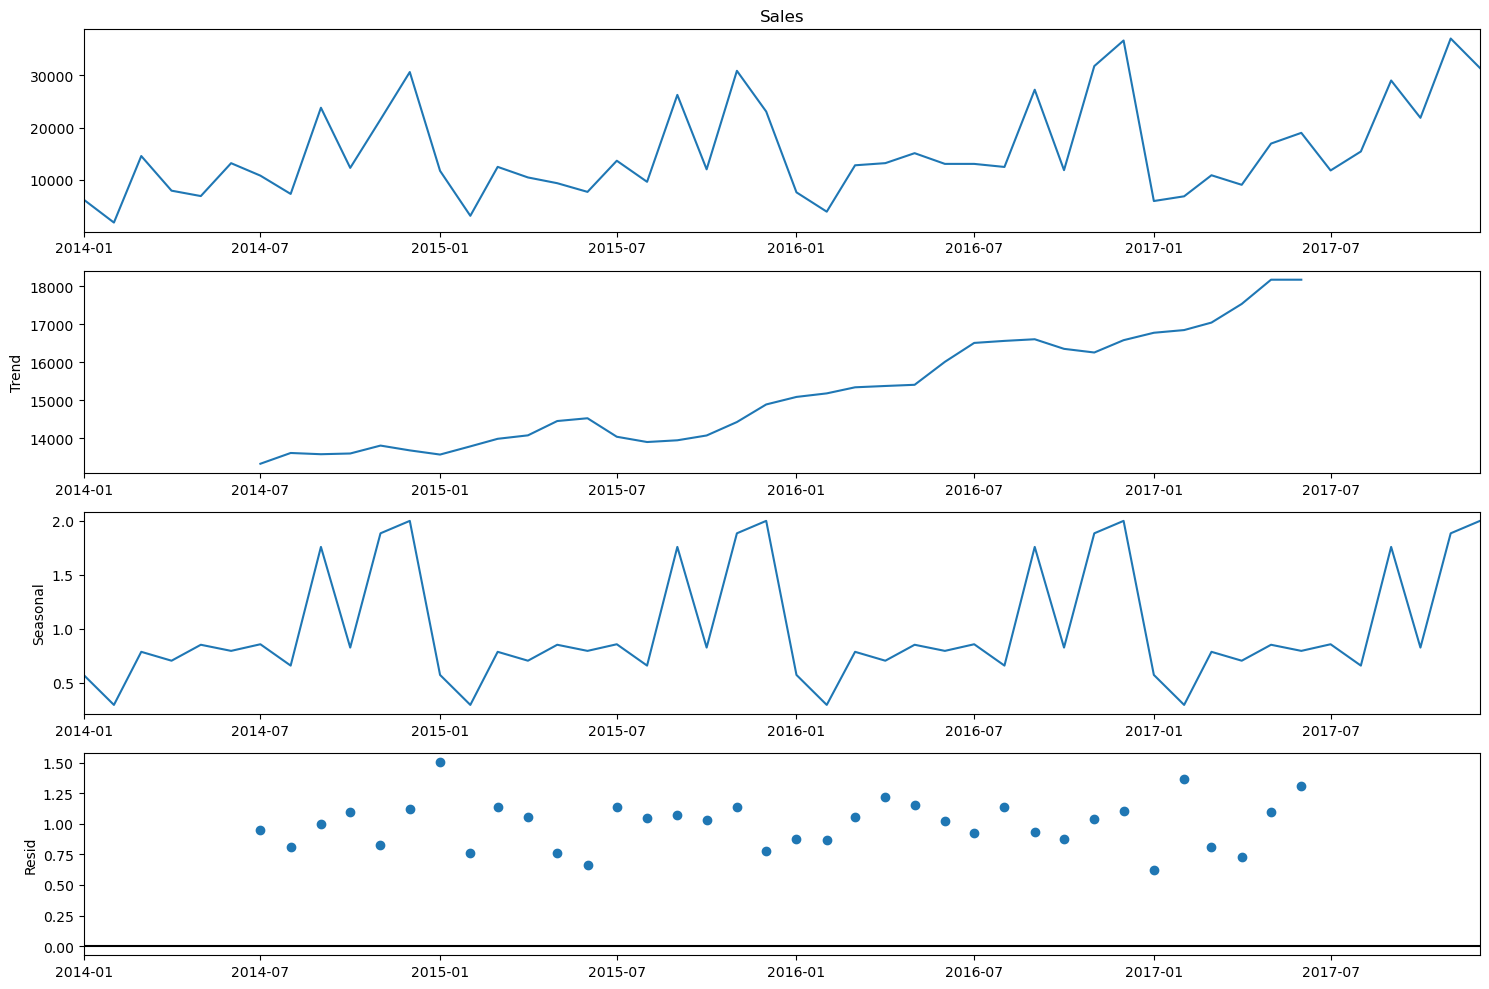

In [31]:
decomposition = sm.tsa.seasonal_decompose(
    furniture_monthly_sales, model='multiplicative'
)
fig = decomposition.plot()
plt.show()

In [32]:
reconstructed_wo_resid = decomposition.trend * decomposition.seasonal

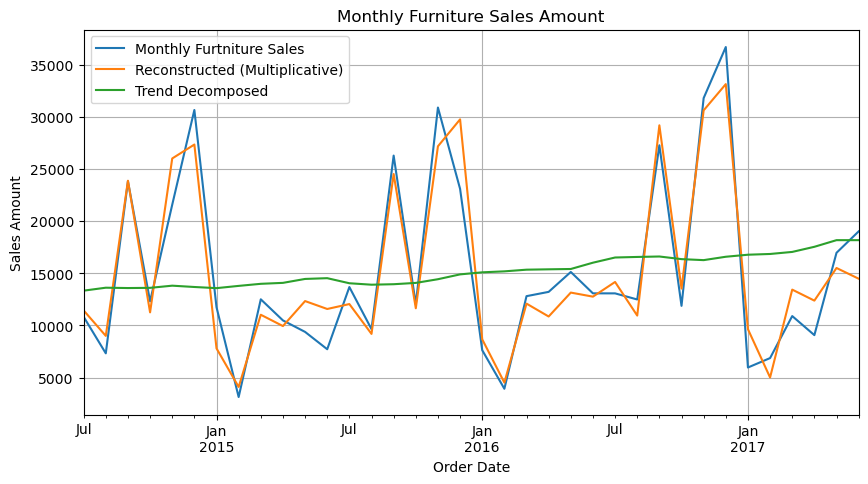

In [33]:
dates = reconstructed_wo_resid.dropna().index
ax = furniture_monthly_sales[dates].plot(figsize=(10,5))
reconstructed_wo_resid[dates].plot(ax=ax, grid=True)
decomposition.trend[dates].plot(ax=ax, grid=True)

ax.set_ylabel("Sales Amount")
ax.set_xlabel("Order Date")
ax.set_title("Monthly Furniture Sales Amount")

plt.legend(["Monthly Furtniture Sales", "Reconstructed (Multiplicative)", "Trend Decomposed"])
plt.show()


In [34]:
corr = np.corrcoef(
    list(furniture_monthly_sales[dates]), 
    list(reconstructed_wo_resid[dates])
)[0,1]
dist = np.sqrt(
    np.square(
        furniture_monthly_sales[dates] - reconstructed_wo_resid[dates]
    ).sum()
)
rmse = np.sqrt(
    np.square(
        furniture_monthly_sales[dates] - reconstructed_wo_resid[dates]
    ).mean()
)

In [35]:
print(f"Correlation: {corr:.02f}\nEuclidean Distance: {dist:.02f}\nRMSE: {rmse:.02f}")

Correlation: 0.95
Euclidean Distance: 15307.16
RMSE: 2551.19


In [36]:
corr, dist, rmse

(0.9525082452367767, 15307.164330949814, 2551.1940551583025)

# 3. Time-Series Forecasting Models

## 3.1. ARIMA

- Auto ARIMA: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [37]:
from statsmodels.tsa.arima.model import ARIMA

In [38]:
furniture_monthly_sales

OrderDate
2014-01-01     6242.5250
2014-02-01     1839.6580
2014-03-01    14573.9560
2014-04-01     7944.8370
2014-05-01     6912.7870
2014-06-01    13206.1256
2014-07-01    10821.0510
2014-08-01     7320.3465
2014-09-01    23816.4808
2014-10-01    12304.2470
2014-11-01    21564.8727
2014-12-01    30645.9665
2015-01-01    11739.9416
2015-02-01     3134.3740
2015-03-01    12499.7830
2015-04-01    10475.6985
2015-05-01     9374.9505
2015-06-01     7714.1790
2015-07-01    13674.4200
2015-08-01     9638.5922
2015-09-01    26273.0230
2015-10-01    12026.6235
2015-11-01    30880.8325
2015-12-01    23085.8192
2016-01-01     7622.7430
2016-02-01     3925.5510
2016-03-01    12801.0920
2016-04-01    13212.0900
2016-05-01    15119.8350
2016-06-01    13070.5720
2016-07-01    13068.5190
2016-08-01    12483.2323
2016-09-01    27262.8809
2016-10-01    11872.5770
2016-11-01    31783.6288
2016-12-01    36678.7150
2017-01-01     5964.0320
2017-02-01     6866.3374
2017-03-01    10893.4448
2017-04-01     

In [39]:
furniture_monthly_sales[:"2017-06-01"]

OrderDate
2014-01-01     6242.5250
2014-02-01     1839.6580
2014-03-01    14573.9560
2014-04-01     7944.8370
2014-05-01     6912.7870
2014-06-01    13206.1256
2014-07-01    10821.0510
2014-08-01     7320.3465
2014-09-01    23816.4808
2014-10-01    12304.2470
2014-11-01    21564.8727
2014-12-01    30645.9665
2015-01-01    11739.9416
2015-02-01     3134.3740
2015-03-01    12499.7830
2015-04-01    10475.6985
2015-05-01     9374.9505
2015-06-01     7714.1790
2015-07-01    13674.4200
2015-08-01     9638.5922
2015-09-01    26273.0230
2015-10-01    12026.6235
2015-11-01    30880.8325
2015-12-01    23085.8192
2016-01-01     7622.7430
2016-02-01     3925.5510
2016-03-01    12801.0920
2016-04-01    13212.0900
2016-05-01    15119.8350
2016-06-01    13070.5720
2016-07-01    13068.5190
2016-08-01    12483.2323
2016-09-01    27262.8809
2016-10-01    11872.5770
2016-11-01    31783.6288
2016-12-01    36678.7150
2017-01-01     5964.0320
2017-02-01     6866.3374
2017-03-01    10893.4448
2017-04-01     

### 3.1.1. Model Fit

In [40]:
model = ARIMA(furniture_monthly_sales[:"2017-06-01"], order=(12,1,3))
model_fit = model.fit()

/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   42
Model:                ARIMA(12, 1, 3)   Log Likelihood                -424.032
Date:                Fri, 12 Apr 2024   AIC                            880.065
Time:                        11:10:23   BIC                            907.482
Sample:                    01-01-2014   HQIC                           890.049
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1478      0.136      1.083      0.279      -0.120       0.415
ar.L2          0.1186      0.122      0.969      0.332      -0.121       0.358
ar.L3         -0.0144      0.128     -0.112      0.9

### 3.1.2. Model Diagnostics

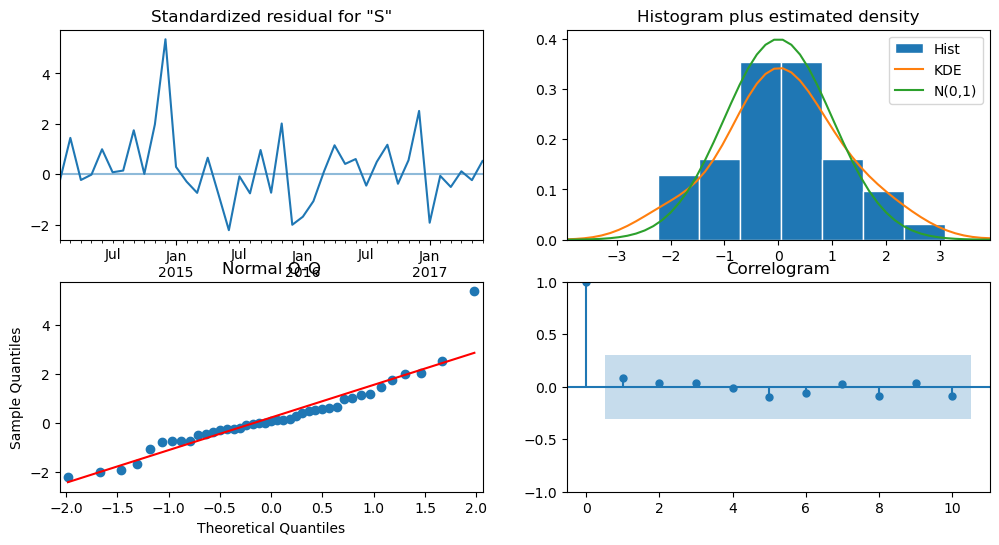

In [42]:
model_fit.plot_diagnostics(figsize=(12, 6))
plt.show()

### 3.1.3. Predictions

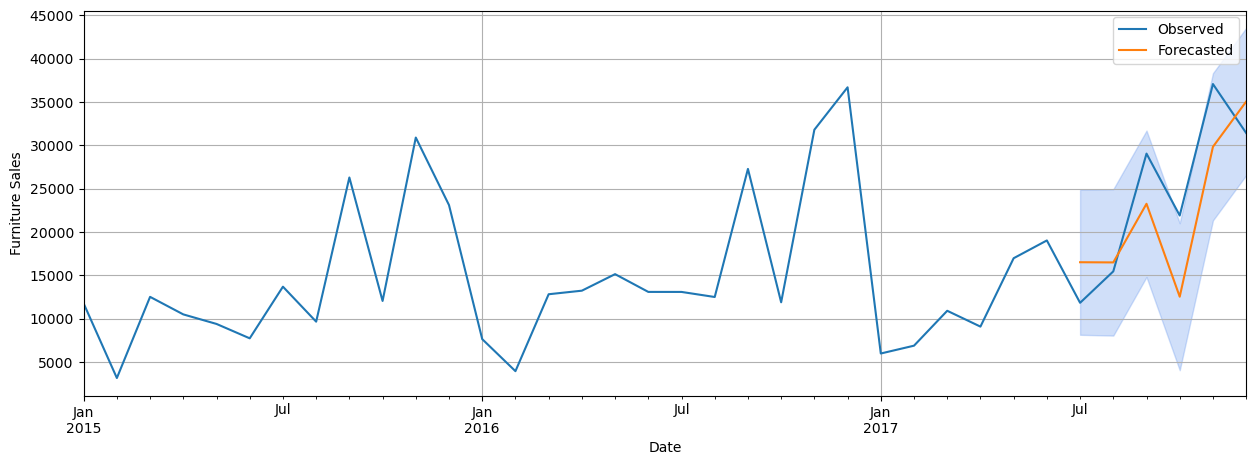

In [43]:
pred = model_fit.get_forecast(steps=6)
pred_ci = pred.conf_int()
ax = furniture_monthly_sales["2015-01-01":].plot(figsize=(15,5))
pred.predicted_mean.plot(
    ax=ax, grid=True
)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], 
    color='cornflowerblue', 
    alpha=.3
)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend(["Observed", "Forecasted"])
plt.show()

In [44]:
pred.predicted_mean

2017-07-01    16495.242409
2017-08-01    16473.069305
2017-09-01    23239.562067
2017-10-01    12517.480902
2017-11-01    29814.051803
2017-12-01    35028.720191
Freq: MS, Name: predicted_mean, dtype: float64

In [45]:
furniture_monthly_sales["2017-07-01":]

OrderDate
2017-07-01    11813.0220
2017-08-01    15441.8740
2017-09-01    29028.2060
2017-10-01    21884.0682
2017-11-01    37056.7150
2017-12-01    31407.4668
Freq: MS, Name: Sales, dtype: float64

In [46]:
rmse = np.sqrt(
    np.square(furniture_monthly_sales["2017-07-01":] - pred.predicted_mean).mean()
)
rmse

5913.227463714012

## 3.2. Prophet

In [47]:
from prophet import Prophet

In [48]:
monthly_furniture_sales_df = pd.DataFrame(furniture_monthly_sales[:"2016-12-01"]).reset_index()
monthly_furniture_sales_df.columns = ["ds", "y"]
monthly_furniture_sales_df.tail()

,ds,y
31,2016-08-01,12483.2323
32,2016-09-01,27262.8809
33,2016-10-01,11872.5770
34,2016-11-01,31783.6288
35,2016-12-01,36678.7150


In [49]:
model = Prophet()
model.fit(monthly_furniture_sales_df)

11:10:25 - cmdstanpy - INFO - Chain [1] start processing
11:10:25 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
dates = model.make_future_dataframe(periods=24, freq='MS')
dates

,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
5,2014-06-01
6,2014-07-01
7,2014-08-01
8,2014-09-01
9,2014-10-01


In [51]:
forecast = model.predict(dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,6516.362514,4165.611312,8916.705838
1,2014-02-01,558.820965,-1812.700214,3034.707109
2,2014-03-01,12235.017313,9848.839123,14636.540958
3,2014-04-01,9042.415516,6811.827004,11356.979161
4,2014-05-01,8562.676158,6153.707515,11122.726090


/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/var/folders/cc/n153cd2x6qq8w175v23xx6zh0000gn/T/ipykernel_69995/2684624474.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "k." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(
/v

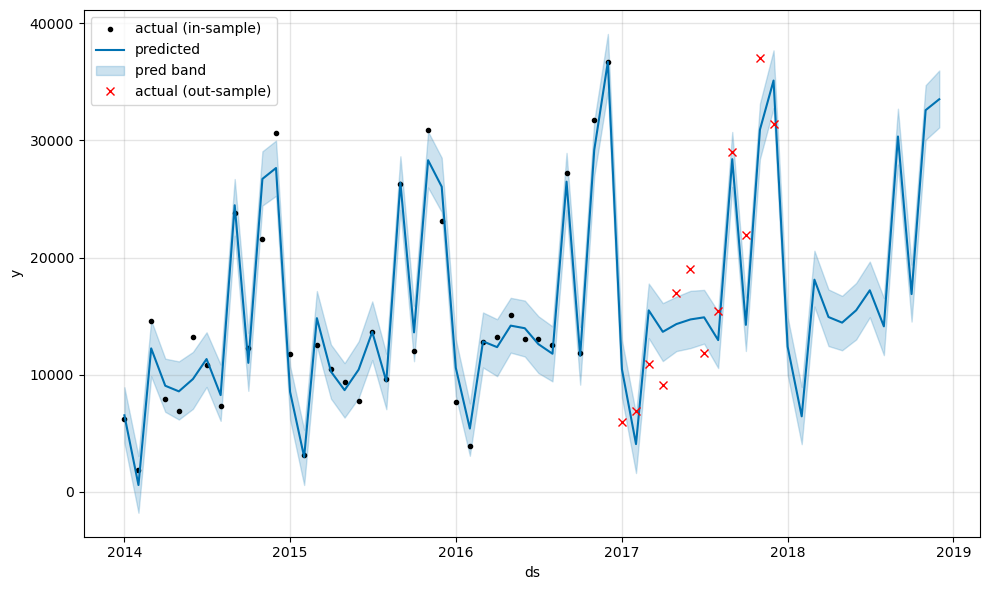

In [52]:
fig = model.plot(forecast, uncertainty=True)
ax = fig.axes[0]

outsample_dates = furniture_monthly_sales["2017-01-01":].index
ax.plot(
    outsample_dates, 
    furniture_monthly_sales.loc[outsample_dates], "k.", marker="x", color="red"
)
plt.legend(["actual (in-sample)", "predicted", "pred band", "actual (out-sample)"])
plt.show()

In [53]:
rmse = np.sqrt(
    np.square(
        forecast.loc[
            forecast["ds"].isin(outsample_dates)
        ]["yhat"].to_numpy() - furniture_monthly_sales.loc[outsample_dates].to_numpy()
    ).mean()
)
print(f"Out-Sample RMSE: {rmse:.02f}")

Out-Sample RMSE: 4295.65


/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an nda

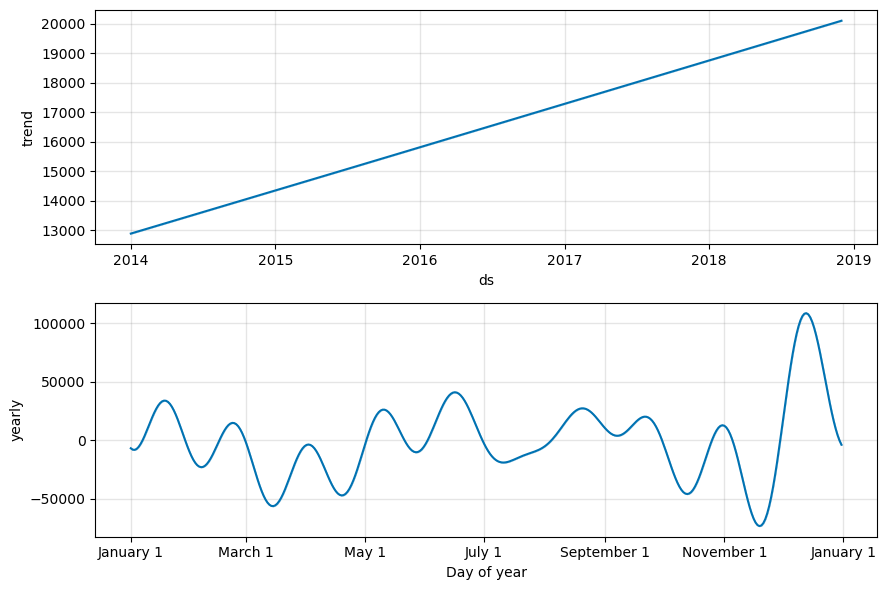

In [54]:
model.plot_components(forecast)
plt.show()

## 3.3. N-BEATS Forecasting

- PyTorch Forecasting

In [55]:
# pip install pytorch-forecasting

In [56]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import NBeats, TimeSeriesDataSet

### 3.3.1. Train Set

In [57]:
furniture_monthly_sales_df = pd.DataFrame(furniture_monthly_sales)
furniture_monthly_sales_df["group_id"] = 0

In [58]:
furniture_monthly_sales_df["time_idx"] = list(range(furniture_monthly_sales_df.shape[0]))

In [59]:
furniture_monthly_sales_df.head()

,Sales,group_id,time_idx
OrderDate,,,
2014-01-01,6242.525,0,0
2014-02-01,1839.658,0,1
2014-03-01,14573.956,0,2
2014-04-01,7944.837,0,3
2014-05-01,6912.787,0,4


In [60]:
max_encoder_length = 12 # 1 year
max_prediction_length = 12 # 1 year

training_cutoff = "2015-12-01"

In [61]:
training = TimeSeriesDataSet(
    furniture_monthly_sales_df[:training_cutoff],
    time_idx="time_idx",
    target="Sales",
    group_ids=["group_id",],
    time_varying_unknown_reals=["Sales",],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)
validation = TimeSeriesDataSet.from_dataset(training, furniture_monthly_sales_df, min_prediction_idx=24)
testset = TimeSeriesDataSet.from_dataset(training, furniture_monthly_sales_df, min_prediction_idx=36)

train_dataloader = training.to_dataloader(train=True)
val_dataloader = validation.to_dataloader(train=False)
test_dataloader = testset.to_dataloader(train=False)

### 3.3.2. Train NBeats Model

In [73]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=250,
    accelerator="auto",
    callbacks=[early_stop_callback],
)


net = NBeats.from_dataset(
    training,
    learning_rate=0.0001,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trai

Sanity Checking: |                                                                                            …

/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

### 3.3.3. Predict

In [74]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [75]:
best_model

NBeats(
  	"backcast_loss_ratio":           0.0
  	"context_length":                12
  	"dropout":                       0.1
  	"expansion_coefficient_lengths": [3, 7]
  	"learning_rate":                 0.0001
  	"log_gradient_flow":             False
  	"log_interval":                  -1
  	"log_val_interval":              -1
  	"logging_metrics":               ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                          MASE()
  	"monotone_constaints":           {}
  	"num_block_layers":              [3, 3]
  	"num_blocks":                    [3, 3]
  	"optimizer":                     Ranger
  	"optimizer_params":              None
  	"output_transformer":            GroupNormalizer(
  		method='standard',
  		groups=[],
  		center=True,
  		scale_by_group=False,
  		transformation='relu',
  		method_kwargs={}
  	)
  	"prediction_length":             12
  	"reduce_on_plateau_min_lr":      1e-05
  	"reduc

In [76]:
val_raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)
test_raw_predictions = best_model.predict(test_dataloader, mode="raw", return_x=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yoonhyuph/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [77]:
val_predictions = val_raw_predictions.output.prediction.numpy()[0]
test_predictions = test_raw_predictions.output.prediction.numpy()[0]

In [78]:
val_trends = val_raw_predictions.output.trend.numpy()[0]
test_trends = test_raw_predictions.output.trend.numpy()[0]

In [79]:
val_seasonality = val_raw_predictions.output.seasonality.numpy()[0]
test_seasonality = test_raw_predictions.output.seasonality.numpy()[0]

In [80]:
furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-val_predictions.shape[0]-test_predictions.shape[0]]:furniture_monthly_sales_df.index[-test_predictions.shape[0]-1], 
    "val_pred"
] = list(val_predictions)

furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-test_predictions.shape[0]]:, "test_pred"
] = list(val_predictions)

furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-val_trends.shape[0]-test_trends.shape[0]]:furniture_monthly_sales_df.index[-test_trends.shape[0]-1], 
    "val_trend"
] = list(val_trends)

furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-test_trends.shape[0]]:, "test_trend"
] = list(test_trends)

furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-val_seasonality.shape[0]-test_seasonality.shape[0]]:furniture_monthly_sales_df.index[-test_seasonality.shape[0]-1], 
    "val_seasonality"
] = list(val_seasonality)

furniture_monthly_sales_df.loc[
    furniture_monthly_sales_df.index[-test_seasonality.shape[0]]:, "test_seasonality"
] = list(test_seasonality)

In [81]:
val_rmse = np.sqrt(np.square((furniture_monthly_sales_df["Sales"] - furniture_monthly_sales_df["val_pred"]).dropna()).mean())
test_rmse = np.sqrt(np.square((furniture_monthly_sales_df["Sales"] - furniture_monthly_sales_df["test_pred"]).dropna()).mean())
print(f"VAL N-BEATS RMSE: {val_rmse:.02f}, TEST N-BEATS RMSE: {test_rmse:.02f}")

VAL N-BEATS RMSE: 7397.91, TEST N-BEATS RMSE: 7914.21


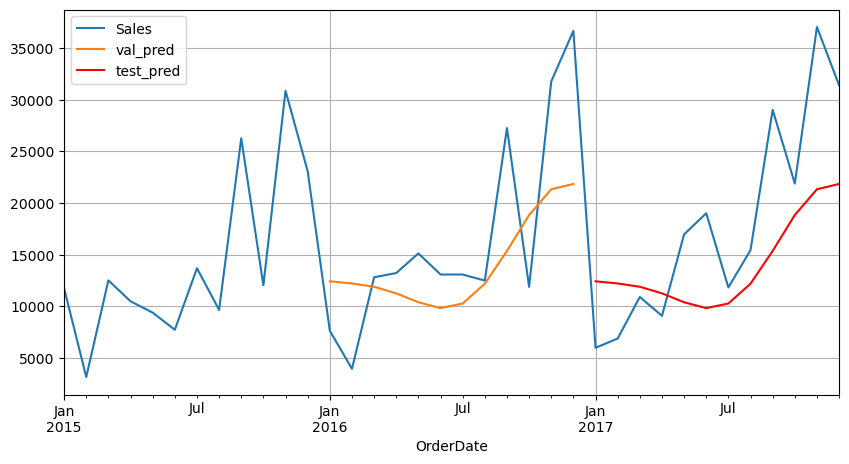

In [82]:
ax = furniture_monthly_sales_df["2015-01-01":][["Sales", "val_pred"]].plot(figsize=(10,5), grid=True)
furniture_monthly_sales_df["2015-01-01":]["test_pred"].plot(ax=ax, grid=True, color="red")

plt.legend()
plt.show()

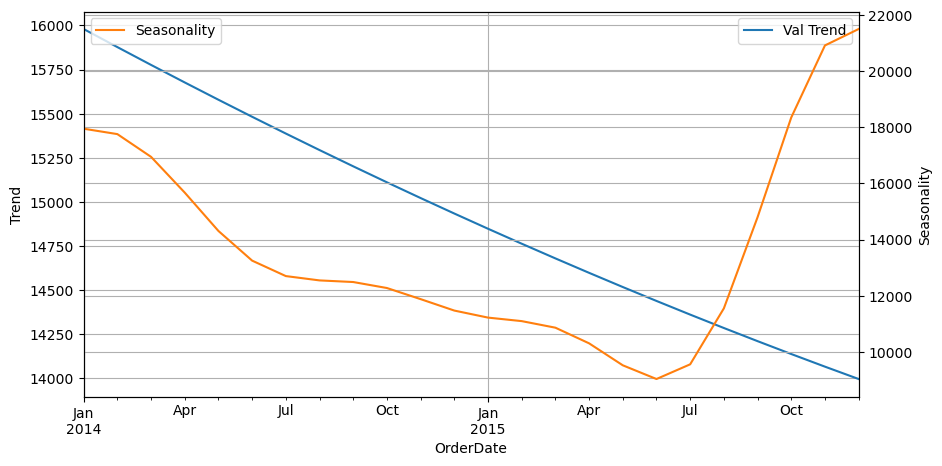

In [83]:
ax = furniture_monthly_sales_df["val_trend"].dropna().plot(figsize=(10,5), grid=True)
furniture_monthly_sales_df["val_seasonality"].dropna().plot(ax=ax, grid=True, secondary_y=True)

ax.set_ylabel("Trend")
ax.right_ax.set_ylabel("Seasonality")

ax.legend(["Val Trend",])
ax.right_ax.legend(["Seasonality",])
plt.show()